<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/10_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%80%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_(DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Распознование автора текста (DNN)**

# 1 Постановка задачи

*Добейтесь точности распознавания 96% и верно распознанных всех писателей с помощью любой нейронной сети. Попробуйте реализовать это без фильтрации данных.*

# 2 Подгрузка библиотек и подключение диска

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files   # Для работы с файлами
import os                        # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils                                  # Для работы с категориальными данными
from tensorflow.keras.models import Sequential                      # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer           # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences   # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder             # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split       # Для разделения выборки на тестовую и обучающую

from google.colab import drive
import time                                                # Библиотека time

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3 Подгрузка данных

In [ ]:
def readText(fileName):          # Объявление функции для чтения файла. На вход подаётся путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Чтение текста
  text = text.replace("\n", " ") # Перевод переносов строк в пробелы

  return text                    # Возвращение текста файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявление интересующих нас классов
nClasses = len(className)                                                         # Подсчёт количества классов

In [ ]:
# Загрузка обучающих текстов

trainText = [] # Формирование обучающих текстов
testText = []  # Формирование тестовых текстов

# Формирование необходимо произвести следующим образом:
# класс каждого i-ого эллемента в обучающей выборке должен соответствовать
# классу каждого i-ого эллемента в тестовой выборке

for i in className:               # Проходим по каждому классу (перечень авторов)
  for j in os.listdir('/content/drive/My Drive/HW_17/texts/'):  # Проходим по каждому файлу в папке с текстами
    if i in j:                    # Проверяем, содержит ли файл j в названии имя класса i (нужно заранее позаботиться о соответствующих названиях файлов)

      if 'Обучающая' in j:        # Если в имени найденного класса есть строка "Обучающая", то:
        trainText.append(readText('/content/drive/My Drive/HW_17/texts/' + j))   # добавляем в обучающую выборку;
        print(j, 'добавлен в обучающую выборку')   # выводим информацию;

      if 'Тестовая' in j:         # Если в имени найденного класса есть строка "Тестовая", то:
        testText.append(readText('/content/drive/My Drive/HW_17/texts/' + j))    # добавляем в обучающую выборку;
        print(j, 'добавлен в тестовую выборку')    # выводим информацию.
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку



(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
# Добавляю вручную тех, кто не подцепился (не понимаю, почему не захотели):

trainText.append(readText('/content/drive/My Drive/HW_17/texts/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/HW_17/texts/(Макс Фрай) Обучающая_5 вместе.txt'))
testText.append(readText('/content/drive/My Drive/HW_17/texts/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/HW_17/texts/(Макс Фрай) Тестовая_2 вместе.txt'))

In [ ]:
print(len(trainText))    # Количество элементов в trainText
print(len(trainText[3])) # Количество символов в первом источнике в trainText

6
1386454


# 4 Преобразование текстовых данных в числовые и векторные (для обучения нейросети)

In [ ]:
cur_time = time.time()  # Засекаем текущее время
maxWordsCount = 30000   # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений.
# num_words = maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов.
# filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - исключение ненужных символов. Можно добавить сюда цифры.
# lower=True          - приведение слов к нижнему регистру
# split = ' '         - разделение пробелами слов, "слипшихся" в результате удаления '\n'
# char_level = False  - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )

# родной: tokenizer = Tokenizer(num_words = maxWordsCount, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower = True, split = ' ', oov_token = 'unknown', char_level = False)
# краденый: tokenizer = Tokenizer(num_words = maxWordsCount, filters=   '!–"—#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
# краденый М (без ?!): tokenizer = Tokenizer(num_words = maxWordsCount, filters = ',()–"—#$%&amp;*+-./:;&lt;=>@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer = Tokenizer(num_words = maxWordsCount, filters = ',()–"—#$%&amp;*+-./:;&lt;=>@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(trainText)             # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())    # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep = '')

Время обработки: 2.63c


In [ ]:
print(items[:10])                     # Просмотр 10 самых часто встречающихся слов
print("Размер словаря", len(items))    # Длина словаря

[('и', 1), ('в', 2), ('не', 3), ('я', 4), ('что', 5), ('на', 6), ('с', 7), ('он', 8), ('а', 9), ('как', 10)]
Размер словаря 155715


In [ ]:
# Преобразовываем текста в последовательность индексов в соответствии с частотным словарём:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)  # Перевод обучающих текстов в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)    # Перевод проверочных текстов в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [532, 22, 29761, 1472, 50, 1, 7705, 4, 410, 28103, 3, 264, 1, 3, 244, 53, 5, 241, 10559, 2696] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0       # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0         # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses):  # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i])       # Подсчёт символов
  wordsTrainText += len(trainWordIndexes[i])  # Подсчёт слов

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0        # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0          # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses):  # Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i])       # Подсчёт символов
  wordsTestText += len(testWordIndexes[i])  # Подсчёт слов
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
О. Генри    1049517 символов,  140665 слов
Стругацкие  2042469 символов,  271856 слов
Булгаков    1765648 символов,  223107 слов
Саймак      1386454 символов,  189780 слов
Фрай        1609507 символов,  230071 слов
Брэдберри   3700010 символов,  510197 слов
----
В сумме  11553605  символов,  1565676  слов 


Статистика по тестовым текстам:
О. Генри    349662 символов,  44145 слов
Стругацкие  704846 символов,  89420 слов
Булгаков    875042 символов,  108252 слов
Саймак      868673 символов,  110505 слов
Фрай        318811 символов,  44951 слов
Брэдберри   1278191 символов,  168109 слов
----
В сумме  4395225  символов,  565382  слов


# 5 Создание обучающей и проверочной выборок

**1.5.1 Функции для формирования выборки по отрезкам текста с заданным шагом**

Формирование обучающей выборки по листу индексов слов
(разделение на короткие векторы)

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):   # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = []                    # Объявление переменной для векторов
  wordsLen = len(wordIndexes)     # Подсчёт количества слов
  index = 0                       # Задаем начальный индекс

  while (index + xLen <= wordsLen):                   # Проходка по всей длине вектора индексов
    xSample.append(wordIndexes[index:index + xLen])   # "Откусываем" векторы длины xLen
    index += step                                     # Смещаеммся вперёд на шаг step

  return xSample

Формирование обучающей и проверочной выборки из двух листов индексов от двух классов

In [ ]:
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов создаём обучающую/проверочную выборку из индексов:
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером [кол-во классов] * [кол-во окон в тексте] * [длина окна]. Пример: с 6 по 1341*1000.
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на [кол-во окон] * [длина окна]

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером [суммарное кол-во окон во всех текстах] * [длина окна]. Например: 15779 * 1000.
  ySamples = [] # Здесь будет список размером [суммарное кол-во окон во всех текстах] * [вектор длиной 6]

  for t in range(nClasses):  # В диапазоне кол-ва классов(6):
    xT = classesXSamples[t]      # берем очередной текст вида [кол-во окон в тексте] * [длину окна]. Например: 1341 * 1000.
    for i in range(len(xT)):     # и каждое его окно:
      xSamples.append(xT[i])                              # добавляем в общий список выборки;
      ySamples.append(utils.to_categorical(t, nClasses))  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)  # Перевод в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples)  # Перевод в массив numpy для подачи в нейронку


  return (xSamples, ySamples)    # Функция возвращает выборку и соответствующие векторы классов

**1.5.2 Подготовка данных**

In [ ]:
# Задание базовых параметров
xLen = 3000  # Длина отрезка текста, по которой анализируем, в словах
step = 300   # Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекание текущего времени
# Формирование обучающей и тестовой выборок
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # Извлечение обучающей выборки
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # Извлечение тестовой выборки
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

# Получен обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(5161, 3000)
(5161, 6)
(1828, 3000)
(1828, 6)
Время обработки: 1.72c


In [ ]:
cur_time = time.time() # Засекаем текущее время

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())  # Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())    # Подаем xTest  в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100])   # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(5161, 30000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1.]
Время обработки: 8.53c


# 6 Функции для проверок статистики по авторам

In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку,
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку,

  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()

  totalSumRec = 0 # Сумма всех правильных ответов

  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан

    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')

  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()

  return totalSumRec/sumCount

xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

# 7 Создание и обучение нейронной сети

*Примечание: в фильтр не включены "?!" / MWC=30000, l=3000, s=300, D=0.35, BS=128, E=30*

Epoch 1/30
41/41 [==============================] - 1s 17ms/step - loss: 1.0832 - accuracy: 0.9411 - val_loss: 1.3845 - val_accuracy: 0.8288
Epoch 2/30
41/41 [==============================] - 1s 14ms/step - loss: 0.8849 - accuracy: 0.9915 - val_loss: 1.3631 - val_accuracy: 0.8605
Epoch 3/30
41/41 [==============================] - 1s 14ms/step - loss: 0.7528 - accuracy: 0.9857 - val_loss: 1.2890 - val_accuracy: 0.8835
Epoch 4/30
41/41 [==============================] - 1s 14ms/step - loss: 0.6207 - accuracy: 0.9806 - val_loss: 1.1525 - val_accuracy: 0.8889
Epoch 5/30
41/41 [==============================] - 1s 14ms/step - loss: 0.5002 - accuracy: 0.9773 - val_loss: 0.9971 - val_accuracy: 0.8857
Epoch 6/30
41/41 [==============================] - 1s 13ms/step - loss: 0.3864 - accuracy: 0.9764 - val_loss: 0.8523 - val_accuracy: 0.8873
Epoch 7/30
41/41 [==============================] - 1s 14ms/step - loss: 0.2991 - accuracy: 0.9779 - val_loss: 0.7064 - val_accuracy: 0.8993
Epoch 8/30
41

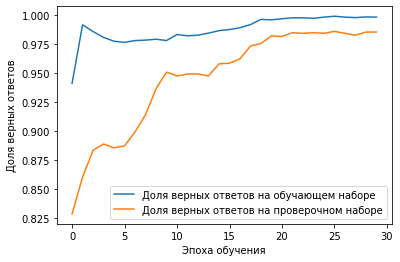

In [ ]:
#Создаём полносвязную сеть (FeedForward Neural Network)
brain_P_05 = Sequential()
brain_P_05.add(BatchNormalization())
brain_P_05.add(Dense(30, input_dim=maxWordsCount, activation="relu"))
brain_P_05.add(Dropout(0.35))
brain_P_05.add(BatchNormalization())
brain_P_05.add(Dense(len(trainText), activation='sigmoid'))
brain_P_05.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = brain_P_05.fit(xTrain01,
                      yTrain,
                      epochs=30,
                      batch_size=128,
                      validation_data=(xTest01, yTest))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# 8 Результаты

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(brain_P_05, xTest6Classes01, "статистика")

НЕЙРОНКА:  статистика

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 99% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     100% сеть отнесла к классу Саймак    Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       99% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  96% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 98%



# 9 Выводы

Поставленная задача выполнена в полной мере:
- подготовлена и обучена нейронная сеть (DNN), предназначенная для определения автора текста;
- достигнута точность 98,5%;
- результаты получены без фильтрации данных.